In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os

In [2]:
os.chdir('../data/interim')

In [3]:
os.listdir()

['.gitkeep',
 'data post-eda.csv',
 'joined data full.csv',
 'joined data post-markdowns.csv',
 'joined data pre-markdowns.csv']

### Generate Dummy Features

My approach is going to be dropping the markdown columns in order to have access to the entire data set for training.

In [4]:
# Loading full joined data as df
df = pd.read_csv('data post-eda.csv')
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Month,Week
0,1,1,2010-01-10,20094.19,0,71.89,2.603,NaN,NaN,NaN,NaN,NaN,211.671989,7.838,2,151315,1,1
1,1,2,2010-01-10,45829.02,0,71.89,2.603,NaN,NaN,NaN,NaN,NaN,211.671989,7.838,2,151315,1,1
2,1,3,2010-01-10,9775.17,0,71.89,2.603,NaN,NaN,NaN,NaN,NaN,211.671989,7.838,2,151315,1,1
3,1,4,2010-01-10,34912.45,0,71.89,2.603,NaN,NaN,NaN,NaN,NaN,211.671989,7.838,2,151315,1,1
4,1,5,2010-01-10,23381.38,0,71.89,2.603,NaN,NaN,NaN,NaN,NaN,211.671989,7.838,2,151315,1,1


In [5]:
# Dropping markdown columns
df.drop(columns=['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], inplace=True)

In [6]:
# Show info of remaining columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  int64  
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   CPI           421570 non-null  float64
 8   Unemployment  421570 non-null  float64
 9   Type          421570 non-null  int64  
 10  Size          421570 non-null  int64  
 11  Month         421570 non-null  int64  
 12  Week          421570 non-null  int64  
dtypes: float64(5), int64(7), object(1)
memory usage: 41.8+ MB


Columns that should have dummy features encoded:
- Store
- Dept
- Type
- Month
- Week

In [7]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,Month,Week
0,1,1,2010-01-10,20094.19,0,71.89,2.603,211.671989,7.838,2,151315,1,1
1,1,2,2010-01-10,45829.02,0,71.89,2.603,211.671989,7.838,2,151315,1,1
2,1,3,2010-01-10,9775.17,0,71.89,2.603,211.671989,7.838,2,151315,1,1
3,1,4,2010-01-10,34912.45,0,71.89,2.603,211.671989,7.838,2,151315,1,1
4,1,5,2010-01-10,23381.38,0,71.89,2.603,211.671989,7.838,2,151315,1,1


I plan to create 3 separate models. One for each of the different store types.

In [8]:
# Create dummy features
deptDummies = pd.get_dummies(df['Dept'], prefix='Dept', drop_first=True)
monthDummies = pd.get_dummies(df['Month'], prefix='Month', drop_first=True)
weekDummies = pd.get_dummies(df['Week'], prefix='Week', drop_first=True)

In [9]:
# Join dummy features onto dataframe
df = df.join([deptDummies, monthDummies, weekDummies])

In [10]:
# Drop original features
df.drop(columns=['Dept', 'Month', 'Week'], inplace=True)

In [11]:
# Split the data by 3 store types
df0 = df.loc[df.Type == 0]
df1 = df.loc[df.Type == 1]
df2 = df.loc[df.Type == 2]

In [12]:
# Drop Type and Date features
df0 = df0.drop(columns=['Type'])
df1 = df1.drop(columns=['Type'])
df2 = df2.drop(columns=['Type'])

In [13]:
# Create Store Dummy Features
storeDummies0 = pd.get_dummies(df0['Store'], prefix='Store', drop_first=True)
storeDummies1 = pd.get_dummies(df1['Store'], prefix='Store', drop_first=True)
storeDummies2 = pd.get_dummies(df2['Store'], prefix='Store', drop_first=True)

In [14]:
# Join Store dummes to dataframes
df0 = df0.join(storeDummies0)
df1 = df1.join(storeDummies1)
df2 = df2.join(storeDummies2)

In [15]:
# Drop Store columns from dataframes
df0 = df0.drop(columns=['Store'])
df1 = df1.drop(columns=['Store'])
df2 = df2.drop(columns=['Store'])

In [16]:
# Print dataframe shapes
print(df0.shape)
print(df1.shape)
print(df2.shape)

(42597, 155)
(163495, 166)
(215478, 171)


### Train Test Split

We want to perform a train test split prior to scaling the data to prevent data leakage

In [17]:
trainmask0 = df0.Date < '2012-01-01'
testmask0 = df0.Date >= '2012-01-01'
trainmask1 = df1.Date < '2012-01-01'
testmask1 = df1.Date >= '2012-01-01'
trainmask2 = df2.Date < '2012-01-01'
testmask2 = df2.Date >= '2012-01-01'

In [18]:
dftrain0 = df0.loc[trainmask0]
dftest0 = df0.loc[testmask0]
dftrain1 = df1.loc[trainmask1]
dftest1 = df1.loc[testmask1]
dftrain2 = df2.loc[trainmask2]
dftest2 = df2.loc[testmask2]

In [19]:
X_train0 = dftrain0.drop(columns=['Date', 'Weekly_Sales'])
y_train0 = dftrain0[['Weekly_Sales']]
X_test0 = dftest0.drop(columns=['Date', 'Weekly_Sales'])
y_test0 = dftest0[['Weekly_Sales']]
X_train1 = dftrain1.drop(columns=['Date', 'Weekly_Sales'])
y_train1 = dftrain1[['Weekly_Sales']]
X_test1 = dftest1.drop(columns=['Date', 'Weekly_Sales'])
y_test1 = dftest1[['Weekly_Sales']]
X_train2 = dftrain2.drop(columns=['Date', 'Weekly_Sales'])
y_train2 = dftrain2[['Weekly_Sales']]
X_test2 = dftest2.drop(columns=['Date', 'Weekly_Sales'])
y_test2 = dftest2[['Weekly_Sales']]

### Apply Scaler Transformation to X_train

In [20]:
# Import StandardScaler
from sklearn.preprocessing import StandardScaler

In [21]:
# Initialize scaler and fit_transform X_train
scaler0 = StandardScaler()
scaler1 = StandardScaler()
scaler2 = StandardScaler()
X_train0[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']] = scaler0.fit_transform(X_train0[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']])
X_train1[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']] = scaler1.fit_transform(X_train1[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']])
X_train2[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']] = scaler2.fit_transform(X_train2[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']])

In [22]:
# Verify that tranformation was successful
X_train0.head()

,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Size,Dept_2,Dept_3,Dept_4,Dept_5,...,Week_48,Week_49,Week_50,Week_51,Week_52,Store_37,Store_38,Store_42,Store_43,Store_44
1993,0,0.232973,-1.410129,1.021646,-0.546596,2.039619,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1994,0,0.232973,-1.410129,1.021646,-0.546596,2.039619,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1995,0,0.232973,-1.410129,1.021646,-0.546596,2.039619,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1996,0,0.232973,-1.410129,1.021646,-0.546596,2.039619,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1997,0,0.232973,-1.410129,1.021646,-0.546596,2.039619,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# Apply scaler transformation to test data
X_test0[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']] = scaler0.transform(X_test0[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']])
X_test1[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']] = scaler1.transform(X_test1[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']])
X_test2[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']] = scaler2.transform(X_test2[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']])

### Modeling
#### I will initially focus on store Type 0 and then apply successful modeling strategy to Type 1 and Type 2 once established

Let's try a standard linear regression to start

In [24]:
# Import module
from sklearn.linear_model import LinearRegression

In [25]:
# Instantiate regressor
reg = LinearRegression()

In [26]:
# Fit to training data
reg.fit(X_train0, y_train0)

LinearRegression()

In [27]:
# Predict on test data
y_pred0 = reg.predict(X_test0)

In [28]:
# R2 score of training data
reg.score(X_train0, y_train0)

0.9016022666941474

In [29]:
from sklearn.metrics import mean_squared_error

In [30]:
# Root-mean-squared error score
mean_squared_error(y_test0, y_pred0, squared=False)

741271290723242.8

In [31]:
from sklearn.metrics import r2_score

In [32]:
# R2 score of test data
r2_score(y_test0, y_pred0)

-2.045229849306764e+21

Standard linear regression performed very poorly

Let's try a Random Forest Regression to see if it does any better

In [33]:
from sklearn.ensemble import RandomForestRegressor

In [161]:
# Elbow plot to determine appropriate max_depth to use

ndepth = []
nrmse = []

for i in range(2, 31):
    reg = RandomForestRegressor(max_depth=i, random_state=42)
    reg.fit(X_train0, np.ravel(y_train0))
    y_pred0 = reg.predict(X_test0)
    nrmse.append(mean_squared_error(y_test0, y_pred0, squared=False))
    ndepth.append(i)

In [162]:
RFElbow = pd.DataFrame({'Max Depth':ndepth, 'Root-Mean-Squared Error':nrmse})

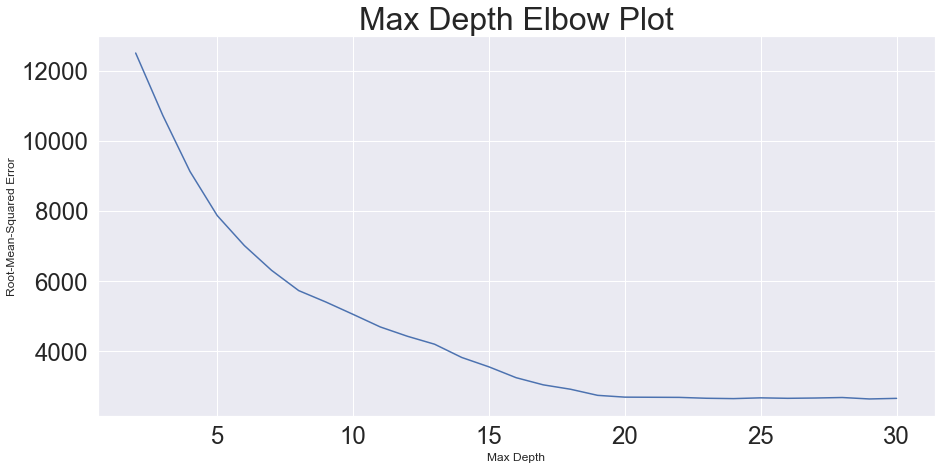

In [178]:
fig = plt.figure(figsize=(15,7))
_ = sns.lineplot(x='Max Depth', y='Root-Mean-Squared Error', data=RFElbow)
_ = plt.title('Max Depth Elbow Plot - Store 0')

It looks like 19 is a good max depth for Random Forest Regression

In [56]:
# Let's try max_depth = 19 on df0
reg0 = RandomForestRegressor(max_depth=19, random_state=42)
reg0.fit(X_train0, np.ravel(y_train0))
y_pred0 = reg0.predict(X_test0)
print('Random Forest - Max Depth 19 - Store Type 0')
print('R2 training score = ' + str(round(reg0.score(X_train0, y_train0), 4)))
print('R2 testing score = ' + str(round(r2_score(y_test0, y_pred0), 4)))
print('Root-mean-squared test score ' + str(round(mean_squared_error(y_test0, y_pred0, squared=False))))

Random Forest - Max Depth 19 - Store Type 0
R2 training score = 0.9868
R2 testing score = 0.9719
Root-mean-squared test score 2747.0


Let's do the same operations for for df1

In [186]:
# Elbow plot to determine appropriate max_depth to use

ndepth = []
nrmse = []

for i in range(3, 25):
    reg = RandomForestRegressor(max_depth=i, random_state=42)
    reg.fit(X_train1, np.ravel(y_train1))
    y_pred1 = reg.predict(X_test1)
    nrmse.append(mean_squared_error(y_test1, y_pred1, squared=False))
    ndepth.append(i)

In [187]:
RFElbow = pd.DataFrame({'Max Depth':ndepth, 'Root-Mean-Squared Error':nrmse})

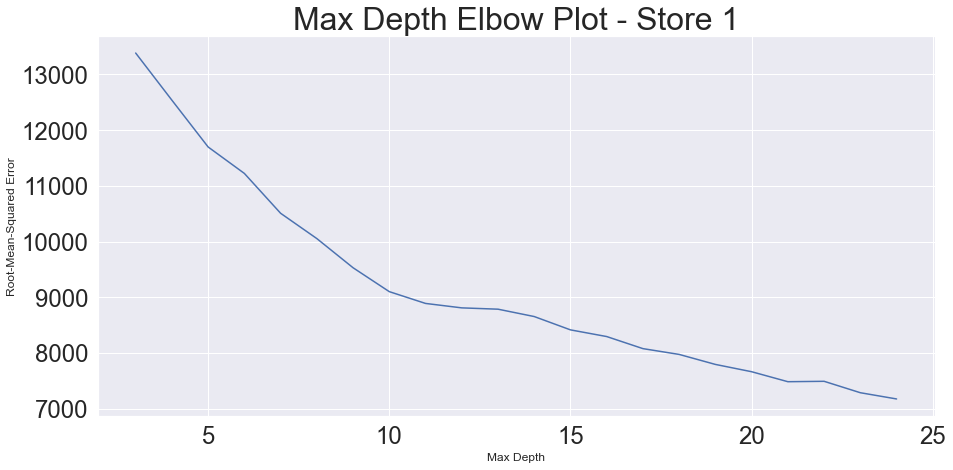

In [188]:
fig = plt.figure(figsize=(15,7))
_ = sns.lineplot(x='Max Depth', y='Root-Mean-Squared Error', data=RFElbow)
_ = plt.title('Max Depth Elbow Plot - Store 1')

Hmm, doesn't seem to level out, let's try a few more iterations.

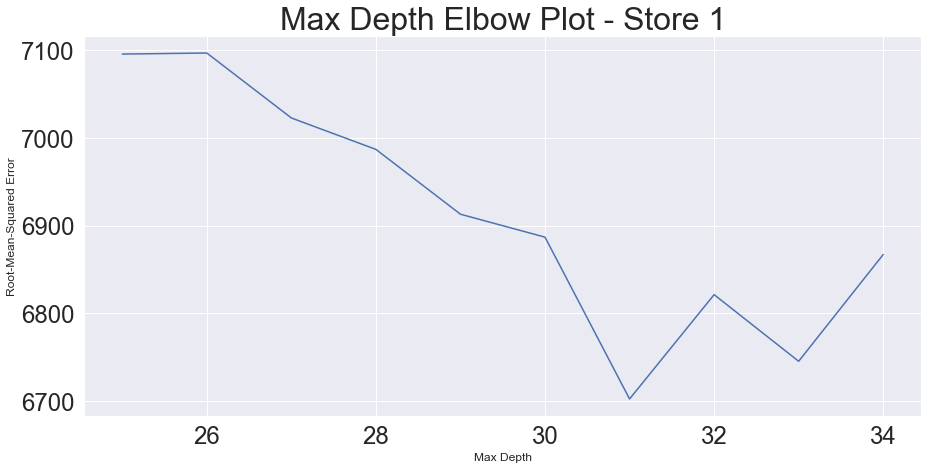

In [189]:
# Elbow plot to determine appropriate max_depth to use

ndepth = []
nrmse = []

for i in range(25, 35):
    reg = RandomForestRegressor(max_depth=i, random_state=42)
    reg.fit(X_train1, np.ravel(y_train1))
    y_pred1 = reg.predict(X_test1)
    nrmse.append(mean_squared_error(y_test1, y_pred1, squared=False))
    ndepth.append(i)

RFElbow = pd.DataFrame({'Max Depth':ndepth, 'Root-Mean-Squared Error':nrmse})

fig = plt.figure(figsize=(15,7))
_ = sns.lineplot(x='Max Depth', y='Root-Mean-Squared Error', data=RFElbow)
_ = plt.title('Max Depth Elbow Plot - Store 1')

Seemed to level off around 30. Let's stick with max depth 19 for store 1

In [190]:
# Let's try max_depth = 19 on df1
reg1 = RandomForestRegressor(max_depth=19, random_state=42)
reg1.fit(X_train1, np.ravel(y_train1))
y_pred1 = reg1.predict(X_test1)
print('Random Forest - Max Depth 19 - Store Type 1')
print('R2 training score = ' + str(round(reg1.score(X_train1, y_train1), 4)))
print('R2 testing score = ' + str(round(r2_score(y_test1, y_pred1), 4)))
print('Root-mean-squared test score ' + str(round(mean_squared_error(y_test1, y_pred1, squared=False))))

Random Forest - Max Depth 19 - Store Type 1
R2 training score = 0.8609
R2 testing score = 0.7577
Root-mean-squared test score 7794.0


In [34]:
# Let's try max_depth = 30 on df1 just to see how much it improves
reg1 = RandomForestRegressor(max_depth=30, random_state=42)
reg1.fit(X_train1, np.ravel(y_train1))
y_pred1 = reg1.predict(X_test1)
print('Random Forest - Max Depth 30 - Store Type 1')
print('R2 training score = ' + str(round(reg1.score(X_train1, y_train1), 4)))
print('R2 testing score = ' + str(round(r2_score(y_test1, y_pred1), 4)))
print('Root-mean-squared test score ' + str(round(mean_squared_error(y_test1, y_pred1, squared=False))))

Random Forest - Max Depth 30 - Store Type 1
R2 training score = 0.9302
R2 testing score = 0.8108
Root-mean-squared test score 6887.0


Decent improvement from 19 to 30 for Store 1

Not as good as store 0

In [192]:
# Let's try max_depth = 19 on df2
reg2 = RandomForestRegressor(max_depth=19, random_state=42)
reg2.fit(X_train2, np.ravel(y_train2))
y_pred2 = reg2.predict(X_test2)
print('Random Forest - Max Depth 19 - Store Type 2')
print('R2 training score = ' + str(round(reg2.score(X_train2, y_train2), 4)))
print('R2 testing score = ' + str(round(r2_score(y_test2, y_pred2), 4)))
print('Root-mean-squared test score ' + str(round(mean_squared_error(y_test2, y_pred2, squared=False))))

Random Forest - Max Depth 19 - Store Type 2
R2 training score = 0.8776
R2 testing score = 0.8609
Root-mean-squared test score 9725.0


In [35]:
# Let's try max_depth = 30 on df2
reg2 = RandomForestRegressor(max_depth=30, random_state=42)
reg2.fit(X_train2, np.ravel(y_train2))
y_pred2 = reg2.predict(X_test2)
print('Random Forest - Max Depth 30 - Store Type 2')
print('R2 training score = ' + str(round(reg2.score(X_train2, y_train2), 4)))
print('R2 testing score = ' + str(round(r2_score(y_test2, y_pred2), 4)))
print('Root-mean-squared test score ' + str(round(mean_squared_error(y_test2, y_pred2, squared=False))))

Random Forest - Max Depth 30 - Store Type 2
R2 training score = 0.9416
R2 testing score = 0.9089
Root-mean-squared test score 7870.0


Decent improvement, but not sure it's worth the cost




#### Let's try picking one specific store and department and testing the model to see how it performs

Lets test on Store 37 (Type 0), Department 2

In [53]:
S37mask0 = X_test0.Store_37 == 1
D2mask0 = X_test0.Dept_2 == 1

In [54]:
S37D2X_test0 = X_test0.loc[S37mask0].loc[D2mask0]
S37D2X_test0IDX = S37D2X_test0.index

In [55]:
S37D2y_test0 = y_test0.loc[S37D2X_test0IDX]

In [57]:
S37D2y_pred0 = reg0.predict(S37D2X_test0)

In [58]:
print('Store 37 - Department 2 - reg0 Model Score')
print('R2 testing score = ' + str(round(r2_score(S37D2y_test0, S37D2y_pred0), 4)))
print('Root-mean-squared test score ' + str(round(mean_squared_error(S37D2y_test0, S37D2y_pred0, squared=False))))

Store 37 - Department 2 - reg0 Model Score
R2 testing score = -0.4374
Root-mean-squared test score 979.0


In [62]:
S37D2df = pd.DataFrame({'y_test':np.ravel(S37D2y_test0), 'y_pred':S37D2y_pred0})

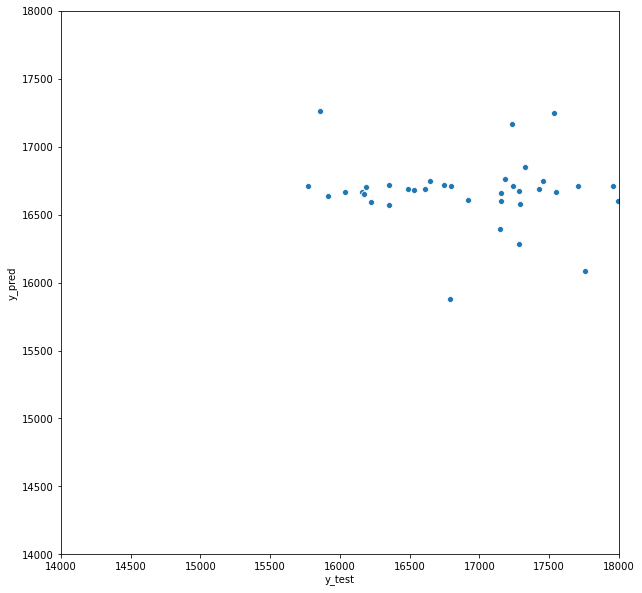

In [69]:
_ = plt.figure(figsize=(10,10))
_ = sns.scatterplot(x='y_test', y='y_pred', data=S37D2df)
_ = plt.xlim(14000, 18000)
_ = plt.ylim(14000, 18000)

Store 5 - Department 2 - reg1 Model Score
R2 testing score = -0.0971
Root-mean-squared test score 795.0


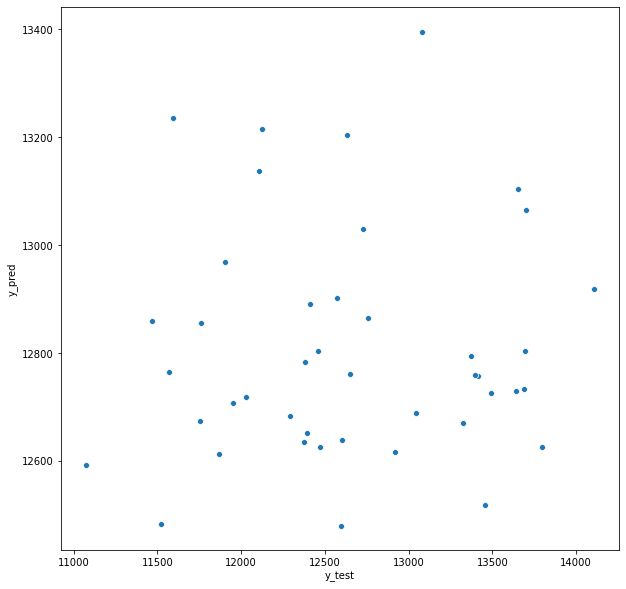

In [74]:
# Lets test on Store 5 (Type 0), Department 2

S5mask1 = X_test1.Store_5 == 1
D2mask1 = X_test1.Dept_2 == 1

S5D2X_test1 = X_test1.loc[S5mask1].loc[D2mask1]
S5D2X_test1IDX = S5D2X_test1.index

S5D2y_test1 = y_test1.loc[S5D2X_test1IDX]

S5D2y_pred1 = reg1.predict(S5D2X_test1)

print('Store 5 - Department 2 - reg1 Model Score')
print('R2 testing score = ' + str(round(r2_score(S5D2y_test1, S5D2y_pred1), 4)))
print('Root-mean-squared test score ' + str(round(mean_squared_error(S5D2y_test1, S5D2y_pred1, squared=False))))

S5D2df = pd.DataFrame({'y_test':np.ravel(S5D2y_test1), 'y_pred':S5D2y_pred1})

_ = plt.figure(figsize=(10,10))
_ = sns.scatterplot(x='y_test', y='y_pred', data=S5D2df)

Let's build a function to do this for each department in each store


In [79]:
def storedepttest(store, dept, reg, X_test, y_test):
    smask = X_test['Store_' + str(store)] == 1
    dmask = X_test['Dept_' + str(dept)] == 1

    SDX_test = X_test.loc[smask].loc[dmask]
    SDX_testIDX = SDX_test.index

    SDy_test = y_test.loc[SDX_testIDX]

    SDy_pred = reg.predict(SDX_test)

    print('Store ' + str(store) + ' - Department ' + str(dept) + ' - Model Score')
    print('R2 testing score = ' + str(round(r2_score(SDy_test, SDy_pred), 4)))
    print('Root-mean-squared test score ' + str(round(mean_squared_error(SDy_test, SDy_pred, squared=False))))

    SDdf = pd.DataFrame({'y_test':np.ravel(SDy_test), 'y_pred':SDy_pred})

    _ = plt.figure(figsize=(10,10))
    _ = sns.scatterplot(x='y_test', y='y_pred', data=SDdf)

In [99]:
type0Stores = [col for col in X_test0.columns if 'Store' in col]
type0Depts = [col for col in X_test0.columns if 'Dept' in col]
type1Stores = [col for col in X_test1.columns if 'Store' in col]
type1Depts = [col for col in X_test1.columns if 'Dept' in col]
type2Stores = [col for col in X_test2.columns if 'Store' in col]
type2Depts = [col for col in X_test2.columns if 'Dept' in col]

In [116]:
type1Stores[0].split('_')[1]

'5'

Store 17 - Department 2 - Model Score
R2 testing score = -1.6668
Root-mean-squared test score 11690.0


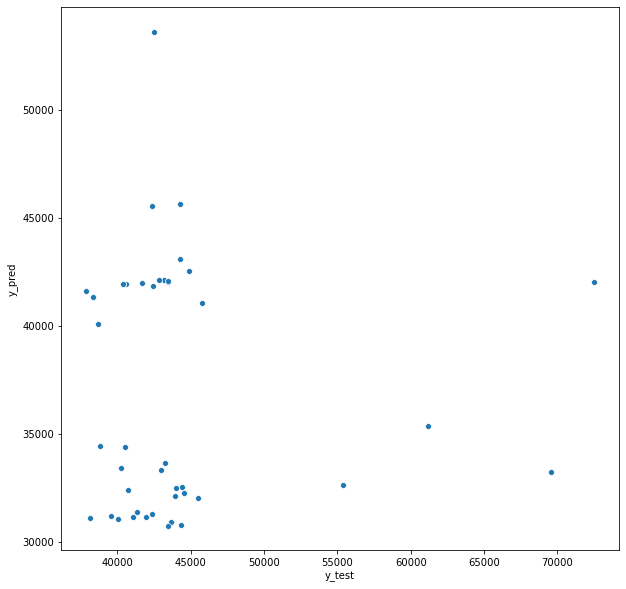

In [115]:
storedepttest(17, 2, reg1, X_test1, y_test1)

*I'm not happy with how this performs on specific stores and departments. I should create different models fit by store Type.*